## libs

In [28]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math as m
from pathlib import Path
from scipy.interpolate import interp1d

## initialization

In [29]:
STARS_DIRECTORY = Path('../sessions/')
ISOCHRONES_DIRECTORY = Path ('../isochrones/')
MAIN_DIRECTORY = Path('../')

In [30]:
def read_file(filename):
    df = pd.read_csv(filename, delimiter='\\s+')
    df = df.apply(pd.to_numeric, errors='coerce')
    try:
        df.dropna(subset = ['phot_g_mean_mag','bp_rp'], inplace = True)
    except:
        pass
    return df

In [31]:
clusters_list = pd.read_excel(MAIN_DIRECTORY / 'cluster_list.xlsx', sheet_name='list', usecols=10, index_col = 0)

/usr/local/lib/python3.7/site-packages/pandas/io/excel.py:527: FutureWarning: Passing in an integer for `usecols` has been deprecated. Please pass in a list of int from 0 to `usecols` inclusive instead.
  usecols = _maybe_convert_usecols(usecols)


In [32]:
clusters_list

,Age,Distance,E(B-V),G_abs_min,bp_rp_min,G_turnoff,G_abs_touch,G_abs_max,G_abs(18)
Cluster,,,,,,,,,
NGC_188,9.780,1800,0.092,3.2,0.95,15.20,5.5,8.5,6.5
NGC_1647,8.550,540,0.354,-1.0,0.70,10.70,3.0,10.0,8.3
NGC_6819,9.300,2560,0.237,2.0,0.93,15.37,5.5,7.5,5.3
NGC_1662,8.695,420,0.300,0.0,0.70,10.25,3.0,10.5,9.0
NGC_1912,8.350,1144,0.333,-1.0,0.49,11.90,3.0,9.0,6.8
NGC_1039,8.380,470,0.077,-0.3,0.10,9.70,2.5,11.5,9.4
NGC_2099,8.695,1400,0.300,-0.5,0.60,12.49,3.0,9.0,6.4
NGC_2516,8.300,400,0.077,-2.0,0.19,9.00,2.0,11.0,9.8
NGC_6866,8.640,1326,0.271,-0.5,0.40,11.90,2.5,9.0,6.6


# working with clusters' data

In [33]:
clusters_list['BP_RP_min'] = clusters_list['bp_rp_min'] - 1.33104 * clusters_list['E(B-V)']
clusters_list['G_abs_turnoff'] = (clusters_list['G_turnoff'] + 5 - 
                                  5 * np.log10(clusters_list['Distance'])
                                  - 2.749632 * (clusters_list['E(B-V)']))

In [34]:
for cluster_name in clusters_list.index.values:
    AGE = clusters_list.loc[f'{cluster_name}','Age']
    isochrone = read_file(ISOCHRONES_DIRECTORY / (f'{cluster_name}_{AGE}.txt'))
    isochrone = isochrone[isochrone['Gmag'] > clusters_list.loc[cluster_name,'G_abs_min']]
    isochrone['BP_RP'] = isochrone['G_BPmag'] - isochrone['G_RPmag']
    
    closest_G_18_isochrone = isochrone.iloc[abs(isochrone['Gmag'] - clusters_list.loc[cluster_name,'G_abs(18)']).idxmin()]
    clusters_list.loc[cluster_name,'BP_RP_max'] = closest_G_18_isochrone['BP_RP'] 
    
    clusters_list.loc[cluster_name,'Mass_min'] = closest_G_18_isochrone['Mass']
    clusters_list.loc[cluster_name,'Mass_max'] = isochrone.iloc[abs(isochrone['BP_RP'] - 
                                                 clusters_list.loc[cluster_name,'BP_RP_min']).idxmin()]['Mass']

In [35]:
clusters_old = ['NGC_188', 'NGC_6819']
BP_RP_min = clusters_list.drop(clusters_old)['BP_RP_min'].max()
BP_RP_max = clusters_list.drop(clusters_old)['BP_RP_max'].min()

## definition parameters' interval

In [36]:
for cluster_name in clusters_list.index.values:
    cluster = read_file(STARS_DIRECTORY / f'{cluster_name}_selected_2')
    cluster['Gmag'] = (cluster['phot_g_mean_mag'] + 5 - 5 * np.log10(clusters_list.loc[cluster_name,'Distance'])
                - 2.749632 * (clusters_list.loc[cluster_name, 'E(B-V)']))
    cluster['BP_RP'] = cluster['bp_rp'] - 1.33104 * clusters_list.loc[cluster_name,'E(B-V)']
    
    mask = ((cluster['Gmag'] > clusters_list.loc[cluster_name,'G_abs_turnoff']) &
            (cluster['BP_RP'] <= BP_RP_max) &
            (cluster['BP_RP'] >= BP_RP_min)
           )
    
    cluster_cleaned = cluster[mask]
    clusters_list.loc[cluster_name,'N'] = len(cluster_cleaned['source_id'])
    
    cluster_cleaned.to_csv(STARS_DIRECTORY / f'{cluster_name}_selected_interval', sep=' ', index=False, na_rep='NULL')

## age, distance and stars' number distributions 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11d68a748>]],
      dtype=object)

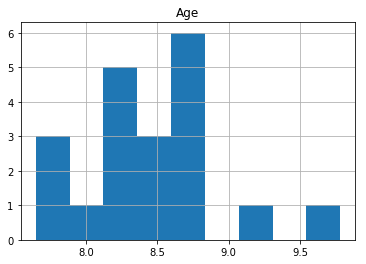

In [38]:
clusters_list.hist(column='Age', bins=9)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11d6d3358>]],
      dtype=object)

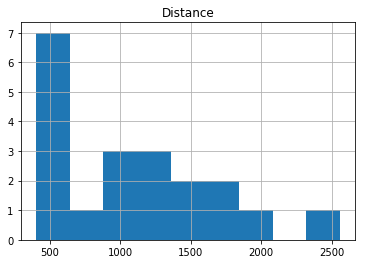

In [39]:
clusters_list.hist(column='Distance', bins=9)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11a01eda0>]],
      dtype=object)

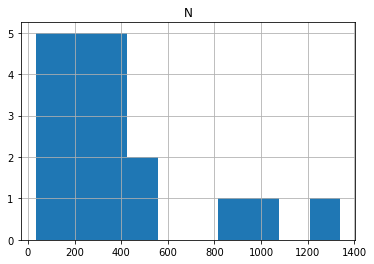

In [40]:
clusters_list.hist(column='N')

## clusters'comparing

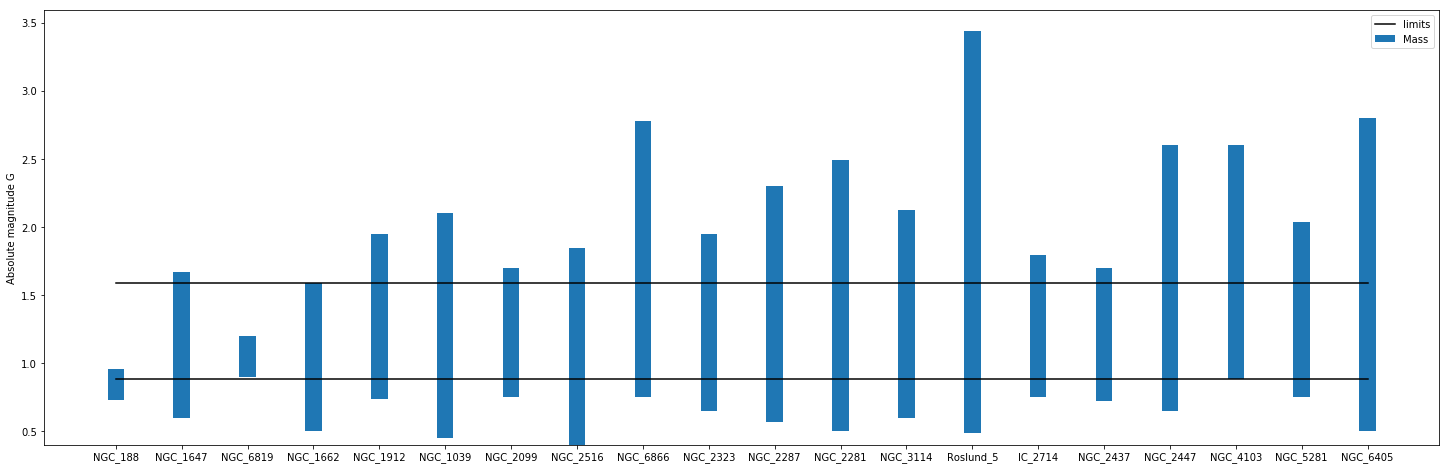

In [45]:
fig, ax = plt.subplots(figsize=(25,8))
N = len(clusters_list['N'])
width = 10
p = plt.bar(np.arange(N), bottom = clusters_list['Mass_min'], 
                 height = clusters_list['Mass_max'] - clusters_list['Mass_min'], 
                 width=0.25, label = 'Mass')

Mass_min = clusters_list.drop(clusters_old)['Mass_min'].max()
Mass_max = clusters_list.drop(clusters_old)['Mass_max'].min()
plt.plot(np.arange(N), np.full(N,Mass_min), c='black', label='limits')
plt.plot(np.arange(N), np.full(N,Mass_max), c='black',label=None)
plt.ylabel('Absolute magnitude G')
plt.xticks(np.arange(N), clusters_list.index.values)
plt.legend(loc='best')
plt.savefig('clusters_Mass_intervals.pdf')

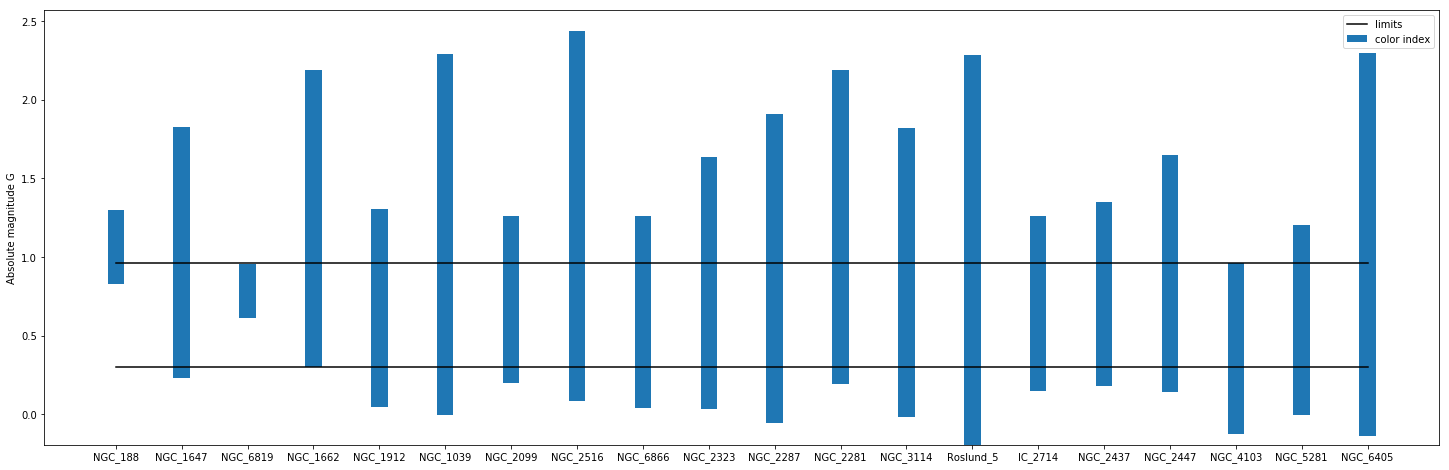

In [42]:
fig, ax = plt.subplots(figsize=(25,8))
N = len(clusters_list['N'])
width = 10
p = plt.bar(np.arange(N), bottom = clusters_list['BP_RP_min'], 
                 height = clusters_list['BP_RP_max'] - clusters_list['BP_RP_min'], 
                 width=0.25, label = 'color index')

plt.plot(np.arange(N), np.full(N,BP_RP_min), c='black', label='limits')
plt.plot(np.arange(N), np.full(N,BP_RP_max), c='black',label=None)
plt.ylabel('Absolute magnitude G')
plt.xticks(np.arange(N), clusters_list.index.values)
plt.legend(loc='best')
plt.savefig('clusters_colors_intervals.pdf')

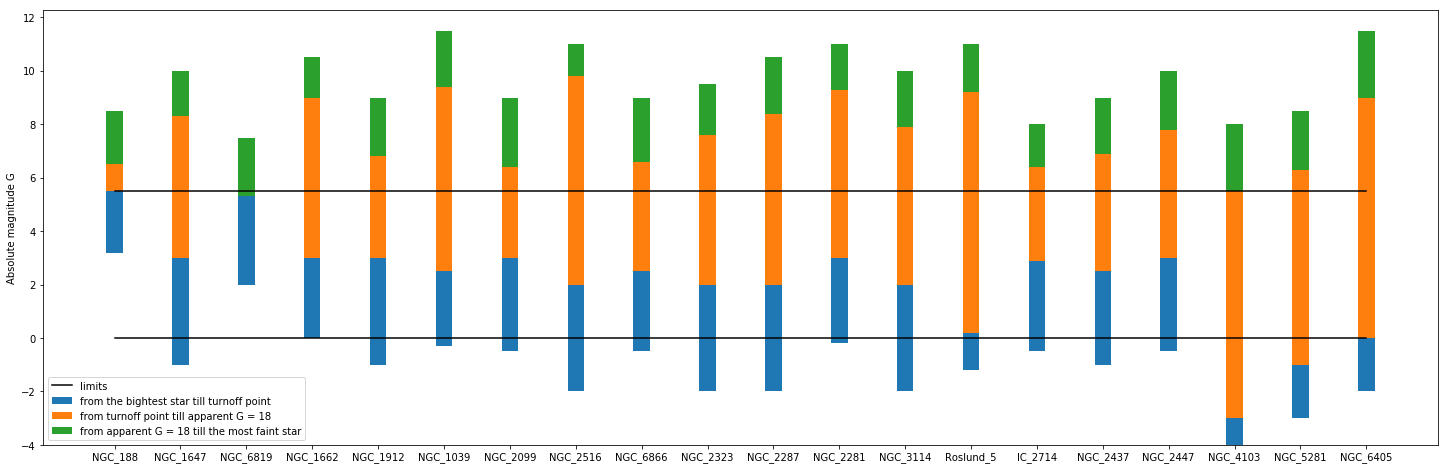

In [43]:
fig, ax = plt.subplots(figsize=(25,8))
N = len(clusters_list['N'])
width = 10
p_high = plt.bar(np.arange(N), bottom = clusters_list['G_abs_min'], 
                 height = clusters_list['G_abs_touch'] - clusters_list['G_abs_min'], 
                 width=0.25, label = 'from the bightest star till turnoff point')
p_till_18 = plt.bar(np.arange(N), bottom = clusters_list['G_abs_touch'], 
                   height = clusters_list['G_abs(18)'] - clusters_list['G_abs_touch'],
                   width=0.25, label = 'from turnoff point till apparent G = 18')
p_till_end = plt.bar(np.arange(N), bottom = clusters_list['G_abs(18)'], 
                     height = clusters_list['G_abs_max'] - clusters_list['G_abs(18)'], 
                     width=0.25, label = 'from apparent G = 18 till the most faint star' )
plt.plot(np.arange(N), np.full(N,0), c='black', label='limits')
plt.plot(np.arange(N), np.full(N,5.5), c='black',label=None)
plt.ylabel('Absolute magnitude G')
plt.xticks(np.arange(N), clusters_list.index.values)
plt.legend()
plt.savefig('clusters_mags_intervals.pdf')

In [44]:
clusters_list_out = clusters_list
#clusters_list_out.to_excel(MAIN_DIRECTORY / 'cluster_list_data.xlsx')